## Compare Binomial & Multinomial Logistic Regression

> Written by Jess Breda September 2023 post lab meeting

A question that came up (from Carlos) was if the mutli-class model would do better on L/R trials if it was trained on L,R,V. The goal of this notebook is to implement this comparison.

**Initial Steps**:

[X] working with simulated data, figure out the dimensions of the multi-class cost

* follow up questions here if needed

[x] working with simulated data, create a binomial class for fitting (from prev code)

[x] create flexible design matrix for binary/multi

[x] validate binomial class finds athena/nick like results with base regressors

*  start with single animal, then expand

[x] write experiment to sweep sigmas for binomial model

[x] see what prev_violation regressor does for binomial model

[ ] figure out how to make train/test split for the models
	
* follow up if diff number of training trials might be an issue

* probably don't want to make this perfect now, but long term good to think about & have this information easily stored
		
[ ] determine what the null model comparison would be (if any?)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pathlib
import sys
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from get_rat_data import *
from animal_performance import *

from method_validation import plot_simulated_weights_binary
from exp_filter import ExpFilter
from binary_logistic_regression import BinaryLogisticRegression
from multiclass_logistic_regression import MultiClassLogisticRegression
from null_model import NullModel

# settings
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dimensions of multi-class cost

In the test eval of the cost function, I want to squash out the third dimension so the model performs better. Eg [1/3 1/3 1/3] should become [1/2 1/2] (or [1/2 1/2 0], not sure yet). Need to focus on figuring out the cost code.

Answer: wrote a new denominator for softmax that only takes into account L/R trials (log_sum_exp_lr()). 

In [22]:
class MultiClassLogisticRegressionComp:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.W = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X: pd.DataFrame, Y: np.ndarray):
        N, D_w_bias = X.shape
        _, C = Y.shape
        initial_W_flat = np.zeros(D_w_bias * C)

        result = minimize(
            fun=self.cost,
            x0=initial_W_flat,
            args=(X.to_numpy(), Y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.W = result.x.reshape(D_w_bias, C)
        return self.W

    def eval(self, X, Y, lr_only=False):
        return self.cost(self.W, X.to_numpy(), Y, sigma=None)

    def cost(self, W, X, Y, sigma, lr_only=False):
        """
        Compute the negative log-likelihood for multi-class
        logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
            for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied
        lr_only : bool (default=False)
            whether to only consider the first two logits (L and R)
            when computing denominator of softmax

        returns
        -------
        - nll : float
            negative log-likelihood
        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W

        # Only consider the first two logits (L and R)
        # when computing denominator of softmax
        if lr_only:
            log_sum_exp_term = self.log_sum_exp_lr(logits)
        else:
            log_sum_exp_term = self.log_sum_exp(logits)

        penalty = (
            (1 / (2 * (sigma**2))) * np.trace(W[1:, :].T @ W[1:, :]) if sigma else 0
        )
        nll = (-np.sum(Y * logits) + np.sum(log_sum_exp_term)) + penalty
        return nll

    def _gradient(self, W, X, Y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        multi-class logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
        for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D+1 * C)
            gradient of the negative log-likelihood

        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        P = self._stable_softmax(logits)

        if sigma:
            penalty_gradient = W / (sigma**2)
        else:
            penalty_gradient = np.zeros_like(W)

        penalty_gradient[0, :] = 0  # No penalty for bias

        gradient = X.T @ (P - Y) + penalty_gradient
        return gradient.flatten()

    @staticmethod
    def log_sum_exp(logits):
        max_logits = np.max(logits, axis=1, keepdims=True)
        return (
            np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def log_sum_exp_lr(logits):
        max_logits = np.max(
            logits[:, :2], axis=1, keepdims=True
        )  # Only consider the first two logits (L and R)
        return (
            np.log(np.sum(np.exp(logits[:, :2] - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def stable_softmax(logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
        return exp_logits / sum_exp

    def generate_data(self, N, D, C, sigma=None, random_state=None):
        """
        Generate data from a multi-class logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        C : int
            number of classes
        sigma : float (default=None)
            standard deviation of true weight matrix, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, C)
            true weight matrix
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C)
            one-hot encoded choice labels for C classes
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # add bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            W = np.random.normal(loc=0, scale=sigma, size=(D + 1, C))
        else:
            W = np.random.normal(loc=0, scale=1, size=(D + 1, C))

        ## Choice Labels
        A = X @ W  # logits
        P = self.stable_softmax(A)
        Y = np.array([np.random.multinomial(1, n) for n in P])

        print(f"Generated {N} samples with {D} features and {C} classes")
        print(f"W is {W.shape} \nX is {X.shape} \nY is {Y.shape}")
        print(f"W has mean {np.mean(W):.3f} and std {np.std(W):.3f}")

        return W, X, Y

In [31]:
sigma = 1.3
model = MultiClassLogisticRegression(sigma=sigma)


N = 100000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes

W, X, Y = model.generate_data(N, D, C, sigma=sigma, random_state=44)

Generated 100000 samples with 4 features and 3 classes
W is (5, 3) 
X is (100000, 5) 
Y is (100000, 3)
W has mean -0.277 and std 1.434


In [33]:
"""Testing on all data"""
lronly_cost = model._cost(W, X, Y, sigma, lr_only=True)

cost = model._cost(W, X, Y, sigma, lr_only=False)

print(f"cost with lr_only = True: {lronly_cost:.3f}")
print(f"cost with lr_only = False: {cost:.3f}")

cost with lr_only = True: -12130.562
cost with lr_only = False: 58004.471


In [34]:
Y[-2:-1]  # Left trial

array([[0, 0, 1]])

In [35]:
"""Testing on left trial only"""
y = Y[-2:-1]
x = X[-2:-1]

lronly_cost = model._cost(W, x, y, sigma, lr_only=True)
cost = model._cost(W, x, y, sigma, lr_only=False)


print(f"cost with lr_only = True: {lronly_cost:.3f}")
print(f"cost with lr_only = False: {cost:.3f}")

cost with lr_only = True: 6.746
cost with lr_only = False: 7.913


## Binary Logistic Regression

### Validate model on simulated data

In [52]:
bmodel = BinaryLogisticRegression(sigma=20, method="L-BFGS-B")
w, X, y = bmodel.generate_data(N=10000, D=2, sigma=1, random_state=None)
result = bmodel.fit(X, y)

Generated 10000 samples with 2 features
w is (3,) 
X is (10000, 3) 
y is (10000,)
w has mean -1.036 and std 0.917
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40496D+03    |proj g|=  2.93776D+03

At iterate    1    f=  5.00291D+03    |proj g|=  1.15366D+03

At iterate    2    f=  4.41442D+03    |proj g|=  5.14037D+02

At iterate    3    f=  4.23496D+03    |proj g|=  1.74757D+02

At iterate    4    f=  4.19721D+03    |proj g|=  8.35617D+01

At iterate    5    f=  4.19390D+03    |proj g|=  6.26644D+01

At iterate    6    f=  4.19207D+03    |proj g|=  3.16557D+00

At iterate    7    f=  4.19206D+03    |proj g|=  1.92170D-01

At iterate    8    f=  4.19206D+03    |proj g|=  1.22753D-02

At iterate    9    f=  4.19206D+03    |proj g|=  9.89971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


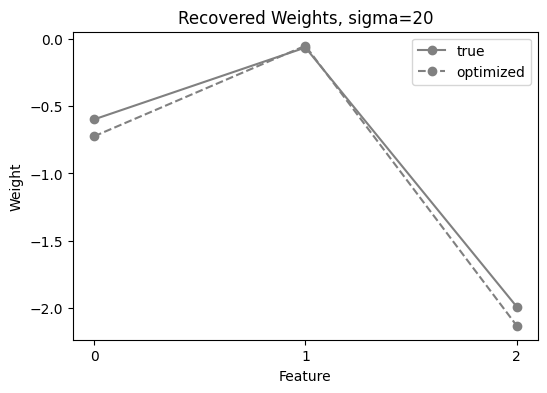

In [49]:
plot_simulated_weights_binary(
    w, result, title=f"Recovered Weights, sigma={bmodel.sigma}"
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68353D+02    |proj g|=  2.63158D+02

At iterate    1    f=  4.82342D+02    |proj g|=  9.11606D+01

At iterate    2    f=  4.46895D+02    |proj g|=  3.93269D+01

At iterate    3    f=  4.34978D+02    |proj g|=  1.29497D+01

At iterate    4    f=  4.32825D+02    |proj g|=  3.17439D+00

At iterate    5    f=  4.32534D+02    |proj g|=  2.65383D+00

At iterate    6    f=  4.32522D+02    |proj g|=  1.32149D-01

At iterate    7    f=  4.32522D+02    |proj g|=  9.61577D-02

At iterate    8    f=  4.32522D+02    |proj g|=  2.48274D-04

At iterate    9    f=  4.32522D+02    |proj g|=  1.62439D-05

At iterate   10    f=  4.32522D+02    |proj g|=  1.04121D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


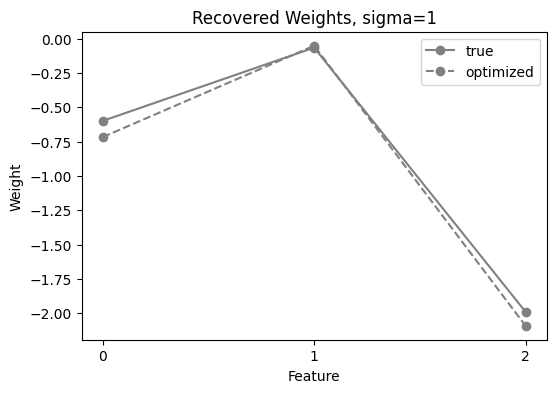

In [50]:
bmodel.sigma = 1
result = bmodel.fit(X, y)

plot_simulated_weights_binary(
    w, result, title=f"Recovered Weights, sigma={bmodel.sigma}"
)

The regularization term effects the ability to recover weights from simulated data. Specifically, a smaller (stronger) sigma gets stuck in a local minima. Made some slides with this summary and plan to continue moving forward

In [53]:
def test_convergence():
    model = BinaryLogisticRegression()
    w_true, X, y = model.generate_data(1000, 5, sigma=None, random_state=44)
    w_fit = model.fit(X, y)
    cost = model.eval(X, y)

    assert cost < 1e-4, f"High cost: {cost}"


test_convergence()

Generated 1000 samples with 5 features
w is (6,) 
X is (1000, 6) 
y is (1000,)
w has mean -0.496 and std 1.294
Optimization terminated successfully.
         Current function value: 327.529704
         Iterations: 21
         Function evaluations: 29
         Gradient evaluations: 29


AssertionError: High cost: 327.52970388390287

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


N, D = 1000, 5

sigma = 1
lambda_ = 1 / (2 * sigma**2)
c = 1 / lambda_

# Initialize your own model and generate data
your_model = BinaryLogisticRegression(sigma=sigma, method="L-BFGS-B", disp=False)
w_true, X, y = your_model.generate_data(N, D, random_state=42)
your_model.fit(pd.DataFrame(X), y)

# Fit sklearn model
sklearn_model = LogisticRegression(penalty="l2", C=c, fit_intercept=False)
sklearn_model.fit(X, y)

# Get weights from both models
your_weights = your_model.w
sklearn_weights = sklearn_model.coef_

# Compute the MSE between the two sets of weights
mse = mean_squared_error(your_weights, sklearn_weights.ravel())

print(f"MSE between your model and sklearn: {mse}")
print("True weights:", w_true)
print("Your weights:", your_weights)
print("Sklearn weights:", sklearn_weights.ravel())

assert mse < 1e-2, "The MSE between the weights is too high!"

Generated 1000 samples with 5 features
w is (6,) 
X is (1000, 6) 
y is (1000,)
w has mean 0.343 and std 0.633
MSE between your model and sklearn: 1.0575934604929106e-05
True weights: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696]
Your weights: [ 0.50603847 -0.08543667  0.7871736   1.49299378 -0.26597733 -0.28781067]
Sklearn weights: [ 0.50479748 -0.0860048   0.79044454  1.50001786 -0.26688293 -0.2886686 ]


In [59]:
model = BinaryLogisticRegression(sigma=1)

model.check_gradient(1000, 5)

Generated 1000 samples with 5 features
w is (6,) 
X is (1000, 6) 
y is (1000,)
w has mean 0.141 and std 0.763
Checking gradient with 1000 samples and 5 features and sigma=1
Gradient check difference: 0.053163532672622235


### Recreate Athena/Roy Results

In [92]:
class DesignMatrixGeneratorBinaryMulti:
    def __init__(
        self, animal_id, train_sessions=None, test_sessions=None, verbose=True
    ):
        self.verbose = verbose
        self.animal_id = animal_id
        self.train_sessions = train_sessions
        self.test_sessions = test_sessions

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(
        self,
        df,
        mode="binary",
        violations="none",
        tau=None,
        return_labels=True,
        drop_session_column=False,
    ):
        """
        Function to generate "base" design matrix given a dataframe
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack.

        N = number of trials
        D = number of features

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        mode : str (default="binary")
            wether to use binary or multi-class logistic regression
        violations : str (default="none")
            whether to include violations as a regressor an if so,
            in what form ("prev", "exp" or "none")
        tau: float (default=None)
            if violations is "exp", tau is the time constant for
            the exponential filter (usually animal specific)
        return_label : bool (default = True)
            whether to return one-hot encoded choice labels
        drop_session_column : bool (default = False)
            whether to drop 'session' column. should be set to
            false if doing session based train/test split
            following design matrix generation

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, 3) if multi-class (N, ) if binary
            when return_labels=True.
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]
        X["session"] = df.session

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        X["prev_violation"] = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0)
        prev_violation_mask = X["prev_violation"] == 0

        # # Violation Exp Filter
        if violations == "exp":
            self.exp_filter = ExpFilter(
                tau=tau, verbose=self.verbose, column="prev_violation"
            )
            self.exp_filter.apply_filter_to_dataframe(X)
            X.drop(columns=["prev_violation"], inplace=True)
        elif violations == "none":
            X.drop(columns=["prev_violation"], inplace=True)

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        # if binary, drop the violation trials. if not using
        # prev violations, drop the prev_violation column as well
        if mode == "binary":
            X = X[df["violation"] != 1].reset_index(drop=True)
            # if violations != "prev":
            #     X.drop(columns=["prev_violation"], inplace=True)

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        if drop_session_column:
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            if mode == "binary":
                # make choice vector, drop nans (violations) to match X
                Y = df["choice"].dropna().astype(int).to_numpy()
            elif mode == "multi":
                Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    @staticmethod
    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation: [[1 0 0] , [0 1 0], [0 0 1]]
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

    def apply_session_train_test_split(self, X, Y, filter_violations=False):
        """
        train_sessions = np.array
            sessions for the
        test_values = np.array indices for the test values

        """

        # If train_sessions or test_sessions is not set, generate them
        if self.train_sessions is None or self.test_sessions is None:
            self.train_sessions, self.test_sessions = get_train_test_sessions(
                X, test_size=0.2
            )

        # Filter rows based on session values for X
        X_train = X[X["session"].isin(self.train_sessions)].copy()
        X_test = X[X["session"].isin(self.test_sessions)].copy()

        # Filter rows based on session values for Y
        # Assuming the index of Y corresponds to that of X
        Y_train = Y[X["session"].isin(self.train_sessions).values]
        Y_test = Y[X["session"].isin(self.test_sessions).values]

        X_train.drop(columns=["session"], inplace=True)
        X_test.drop(columns=["session"], inplace=True)

        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

        # Additional code to filter out violations if flag is set
        if filter_violations:
            self.filter_violations_from_test_set()
            return (
                self.X_train,
                self.filtered_X_test,
                self.Y_train,
                self.filtered_Y_test,
            )

        return self.X_train, self.X_test, self.Y_train, self.Y_test

    def filter_violations_from_test_set(self):
        """
        Filters out the violation trials from Y_test and X_test. For
        the multi-class case to allow for comparision with the binary
        case on only L & R trials.

        Assumes that the violation is encoded as [0, 0, 1] in Y_test.
        """
        violation_filter = np.all(self.Y_test == np.array([0, 0, 1]), axis=1)
        non_violation_idx = np.where(~violation_filter)[0]

        self.filtered_Y_test = self.Y_test[non_violation_idx]
        self.filtered_X_test = self.X_test.iloc[non_violation_idx]


def get_train_test_sessions(df, test_size=0.2, random_state=45):
    """
    This function will return a list of sessions to use for training
    and testing respectively. To apply, see function
    see apply_session_train_test_split()


    Parameters:
    -----------
    df : pd.DataFrame
        dataframe with `sessions` column
    test_size : float
        Proportion of data to use for test set
    """
    unique_sessions = df["session"].unique()
    train_sessions, test_sessions = train_test_split(
        unique_sessions, test_size=test_size, random_state=random_state
    )

    return train_sessions, test_sessions

In [21]:
def plot_weights(X, w, ax=None, title=None):
    """
    Plots the weights for each column in the design matrix X.

    Parameters:
    X (numpy.ndarray): The design matrix with shape (m, n)
    w (numpy.ndarray): The weight vector with shape (n,)

    """

    # if X is a df, grab the columns
    if isinstance(X, pd.DataFrame):
        X = X.columns

    if len(X) != len(w):
        raise ValueError("The number of columns in X must match the length of w.")
    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(X, w)
    ax.axhline(0, color="black")

    # aesthetics
    plt.xticks(rotation=45)
    ax.set(
        xlabel="Feature",
        ylabel="Weight Value",
        title="Weight by Feature" if None else title,
    )

In [15]:
animal_id = "W078"

dmg = DesignMatrixGeneratorBinaryMulti(verbose=False, animal_id=animal_id)


animal_df = get_rat_viol_data(animal_ids=animal_id)

X, y = dmg.generate_design_matrix(
    animal_df,
    mode="binary",
    violations="prev",
    tau=5,
    return_labels=True,
    drop_session_column=True,
)

returning viol data for W078


In [17]:
X.prev_violation.value_counts()

prev_violation
0    38175
1     5306
Name: count, dtype: int64

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03084D+04    |proj g|=  5.34772D+03

At iterate    1    f=  2.65035D+04    |proj g|=  3.04059D+03

At iterate    2    f=  2.52866D+04    |proj g|=  2.09021D+03

At iterate    3    f=  2.40124D+04    |proj g|=  6.70530D+02

At iterate    4    f=  2.38994D+04    |proj g|=  5.43453D+02

At iterate    5    f=  2.38608D+04    |proj g|=  1.47760D+02

At iterate    6    f=  2.38499D+04    |proj g|=  1.31497D+02

At iterate    7    f=  2.38423D+04    |proj g|=  9.97703D+01

At iterate    8    f=  2.38366D+04    |proj g|=  9.24123D+01

At iterate    9    f=  2.38366D+04    |proj g|=  9.24123D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


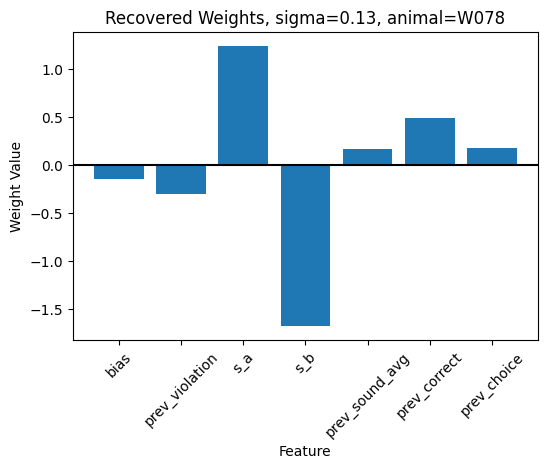

In [23]:
bmodel = BinaryLogisticRegression(sigma=0.13, method="L-BFGS-B")
result = bmodel.fit(X, y)


plot_weights(
    X, result, title=f"Recovered Weights, sigma={bmodel.sigma}, animal={animal_id}"
)

BFGS seems to be having issues, but the weights look as expected. This animal happens to be trained, so sa/sb are opposite and opposed. For other animals (e.g. "W065") this is not the case and the weights favor sb much more. it should be noted that at the trunction for the violations datasets no animals had psychometric stimuli! this also leads to poor fits. 

returning full data for W078


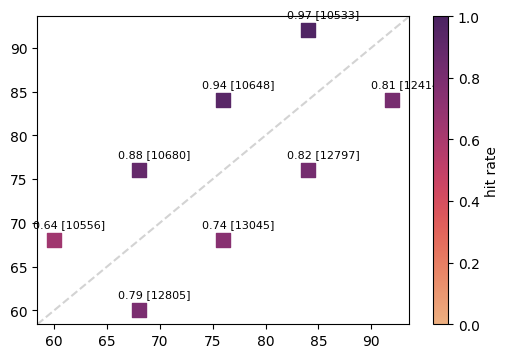

In [76]:
plot_animal_performance_by_stim(animal_id, violations_only=False)

returning viol data for W078


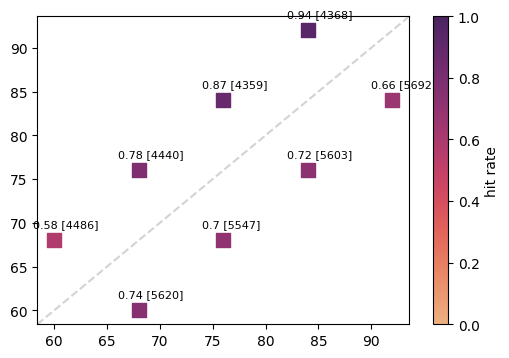

In [77]:
plot_animal_performance_by_stim(animal_id, violations_only=True)

From the plots above, you can see that the full dataset (upper plot) has higher performance and counts for the stimulus pairs. These are across all stages/sessions with stim pairs. I will also fit the model to the full dataset to see the differences in weights. The BFGS errors still persist.

returning full data for W078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62421D+04    |proj g|=  1.77295D+04

At iterate    1    f=  5.48106D+04    |proj g|=  1.23383D+04

At iterate    2    f=  4.66423D+04    |proj g|=  4.04630D+03

At iterate    3    f=  4.53563D+04    |proj g|=  8.18884D+02

At iterate    4    f=  4.52921D+04    |proj g|=  7.05504D+02

At iterate    5    f=  4.52533D+04    |proj g|=  1.78555D+02

At iterate    6    f=  4.52509D+04    |proj g|=  3.62099D+01

At iterate    7    f=  4.52509D+04    |proj g|=  1.31781D+01

At iterate    8    f=  4.52508D+04    |proj g|=  2.85288D+00

At iterate    9    f=  4.52508D+04    |proj g|=  1.17435D+00

At iterate   10    f=  4.52508D+04    |proj g|=  5.17950D-01

At iterate   11    f=  4.52508D+04    |proj g|=  1.06496D-01

           * * *

Tit   = total number of iterations
Tnf   

 This problem is unconstrained.


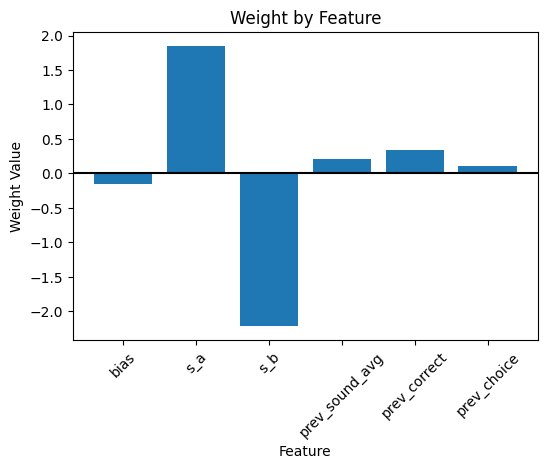

In [78]:
# Get data for a single animal
animal_df = get_rat_data(animal_ids=animal_id)

X, y = dmg.generate_design_matrix(
    animal_df,
    mode="binary",
    violations="none",
    tau=5,
    return_labels=True,
    drop_session_column=True,
)

bmodel = BinaryLogisticRegression(sigma=3, method="L-BFGS-B")
result = bmodel.fit(X, y)

plot_weights(X, result)

### Develop a SigmaSearchBinary Experiment


In [30]:
class SigmaSearchBinary:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.model_names = params["model_names"]
        self.random_state = params["random_state"]
        self.tau = np.nan
        self.test_size = params["test_size"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.stored_fits = []

        if self.animals is None:
            self.animals = self.df.animal_id.unique()
        self.n_animals = len(self.animals)

    def run(self):
        for animal in self.animals:
            print(f"\n\n !!!!! evaluating animal {animal} !!!!!\n\n")
            if self.df.animal_id.nunique() > 1:
                # Load in data for specific animal
                animal_df = self.df.query("animal_id == @animal and training_stage > 2")
            else:
                animal_df = self.df.query("training_stage > 2")

            # Create a DesignMatrixGenerator object & get train/test sessions for animal
            dmg = DesignMatrixGeneratorBinaryMulti(verbose=False, animal_id=animal)
            dmg.get_train_test_sessions(
                animal_df, test_size=self.test_size, random_state=self.random_state
            )

            # Iterate over sigmas
            for sigma in self.sigmas:
                # Generate design matrix & create train/test splits
                X, y = dmg.generate_design_matrix(
                    animal_df,
                    mode="binary",
                    violations="prev",
                    tau=self.tau,
                    return_labels=True,
                )

                print(
                    f"model : {self.model_names}, sigma: {sigma}, tau: {self.tau}, size of X: {X.shape}, Y: {y.shape}"
                )
                (
                    X_train,
                    X_test,
                    y_train,
                    y_test,
                ) = dmg.apply_session_train_test_split(X, y)

                # Fit model & evaluate
                model = BinaryLogisticRegression(sigma=sigma)
                w_fit = model.fit(X_train, y_train)
                nll = model.eval(X_test, y_test)

                # Store model_fits
                self.store(
                    animal,
                    self.model_names[0],
                    nll,
                    sigma,
                    self.tau,
                    w_fit,
                    dmg,
                )

        self.model_fits = pd.concat(self.stored_fits, ignore_index=True)
        return self.model_fits

    def store(self, animal, model_name, nll, sigma, tau, w_fit, dmg):
        # Create a DataFrame for this iteration
        iter_df = pd.DataFrame(
            {
                "animal_id": [animal],
                "model_name": [model_name],
                "nll": [nll],
                "sigma": [sigma],
                "tau": [tau],
                "features": [list(dmg.X_test.columns)],
                "weights": [list(w_fit)],  # Convert numpy array to list
            }
        )
        # Append to the list of stored fits
        self.stored_fits.append(iter_df)

In [31]:
params = {
    "animals": None,
    "sigmas": [0.13, 0.25, 0.5, 1, 2, 4, 8],  # [0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "model_names": ["base"],
    "random_state": 47,
    "test_size": 0.25,
}

experiment = SigmaSearchBinary(params)
results = experiment.run()

returning viol dataset for all animals


 !!!!! evaluating animal W051 !!!!!


model : ['base'], sigma: 0.13, tau: nan, size of X: (46800, 8), Y: (46800,)
         Current function value: 21333.178755
         Iterations: 10
         Function evaluations: 70
         Gradient evaluations: 58
model : ['base'], sigma: 0.25, tau: nan, size of X: (46800, 8), Y: (46800,)
         Current function value: 21366.936393
         Iterations: 11
         Function evaluations: 69
         Gradient evaluations: 57
model : ['base'], sigma: 0.5, tau: nan, size of X: (46800, 8), Y: (46800,)
         Current function value: 21376.841658
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 63
model : ['base'], sigma: 1, tau: nan, size of X: (46800, 8), Y: (46800,)
         Current function value: 21379.359089
         Iterations: 11
         Function evaluations: 75
         Gradient evaluations: 63
model : ['base'], sigma: 2, tau: nan, size of X: (46800, 8), Y: (4680

In [40]:
from model_visualizer import *

mv = ModelVisualizerSweeps(experiment)

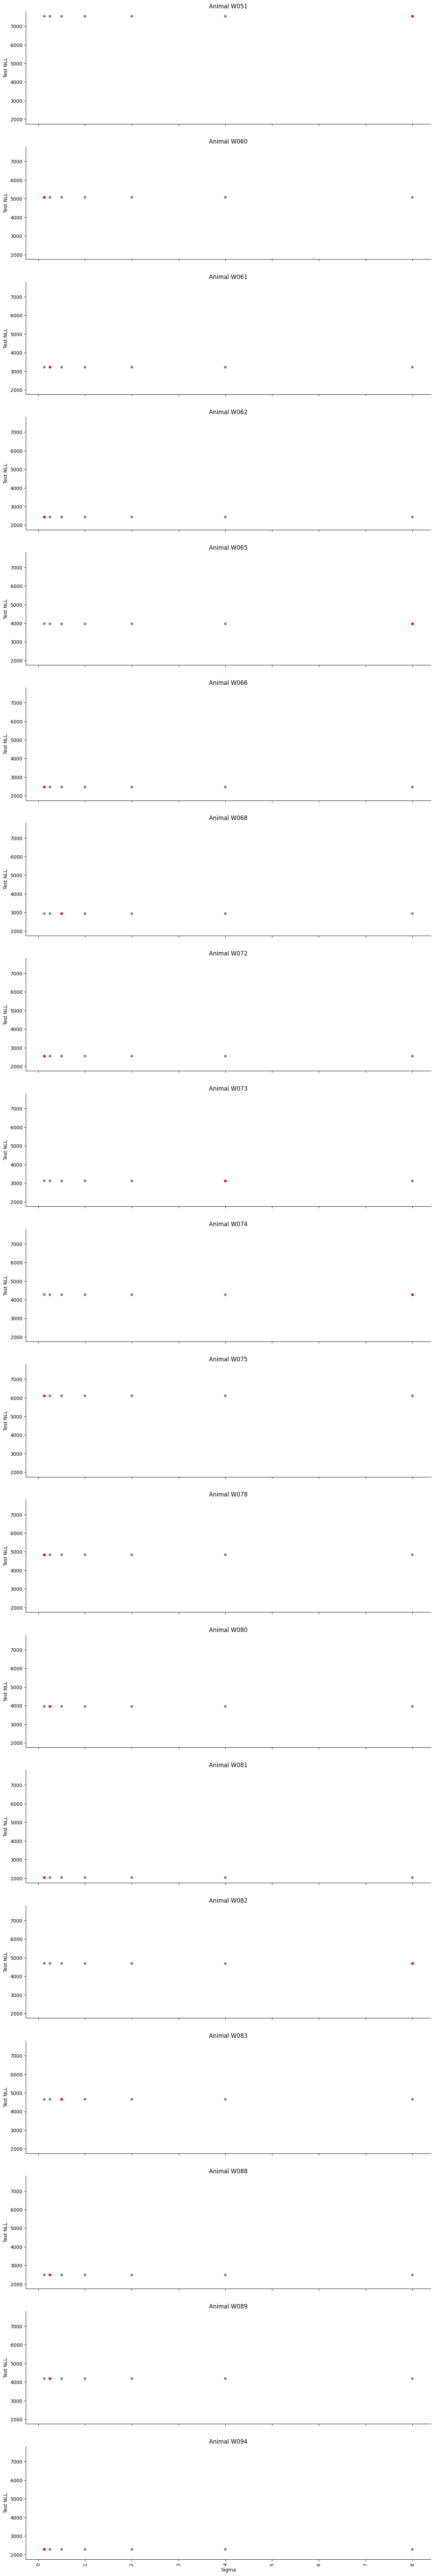

In [35]:
# Plot nll over sigmas

mv.plot_nll_over_sigmas_by_animal()

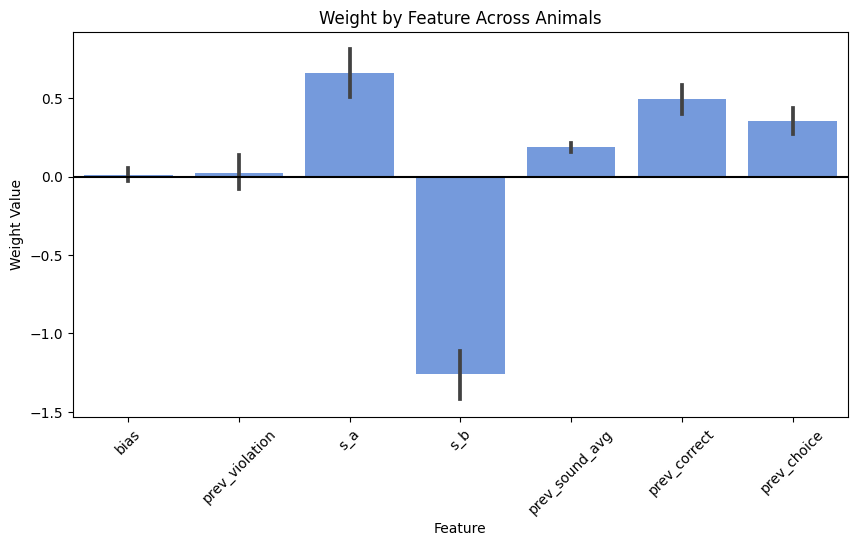

In [48]:
mv.plot_weights_across_animals()

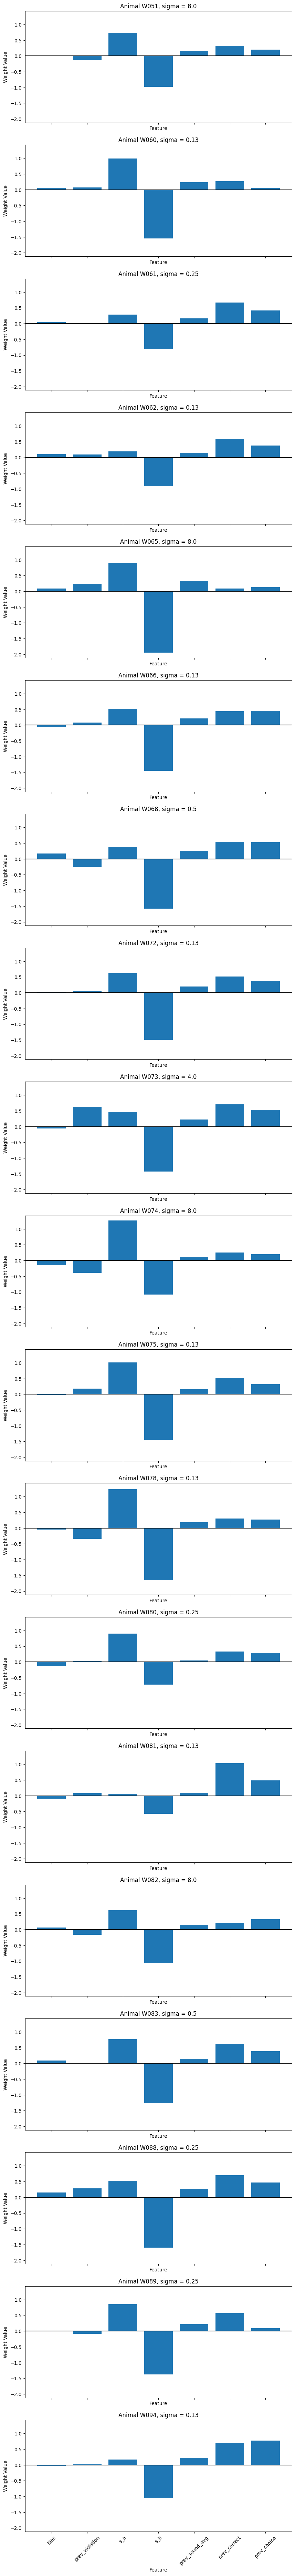

In [36]:
mv.plot_weights_by_animal()

## Creating a L/R test set for multi-class

Here, I need to edit the design matrix generator to make a test set that is only L/R trials for the multi-class model and that this test set matches the same trial for the binary model.

In [49]:
## Psudocode for comparision

# INIT
# model names will be ["binary", "multiclass"]
# there will be no taus here- just prev violations

# FOR EACH ANIMAL
# get the animals df on stage > 2
# [x] get train test sessions
# [x]get X and y for binary
# [x] get X and Y for multi-class (will not have viol dropped)
# [x]apply train/test split to X_binary and y
# [x] apply train/test split to X_multi and Y but note that the
# test set will actually need to not include violation trials
# and there should be some assertion that y_test and Y_test are the same

# fit null model!

# loop over sigmas, and model names(?) and fit models, eval models (correct eval!) and store results

In [5]:
animal_id = "W075"
df = get_rat_viol_data(animal_ids=animal_id)

returning viol data for W075


In [68]:
null_models = []
fit_models = []
fit_models = pd.DataFrame(
    columns=["animal_id", "model_name", "nll", "sigma", "features", "weights"]
)
model_names = ["binary", "multi"]
sigmas = [0.13, 0.26]
train_sessions, test_sessions = get_train_test_sessions(
    df, test_size=0.2, random_state=45
)

binary_matrix_gen = DesignMatrixGeneratorBinaryMulti(
    animal_id=animal_id, train_sessions=train_sessions, test_sessions=test_sessions
)
multi_matrix_gen = DesignMatrixGeneratorBinaryMulti(
    animal_id=animal_id, train_sessions=train_sessions, test_sessions=test_sessions
)

X_binary, y_binary = binary_matrix_gen.generate_design_matrix(
    df, mode="binary", violations="prev", return_labels=True
)

X_multi, Y_multi = multi_matrix_gen.generate_design_matrix(
    df, mode="multi", violations="prev", return_labels=True
)

(
    X_b_train,
    X_b_test,
    y_b_train,
    y_b_test,
) = binary_matrix_gen.apply_session_train_test_split(X_binary, y_binary)

(
    X_m_train,
    X_m_test,
    Y_m_train,
    Y_m_test,
) = multi_matrix_gen.apply_session_train_test_split(
    X_multi, Y_multi, filter_violations=True
)

assert len(multi_matrix_gen.filtered_Y_test) == len(y_b_test)
assert multi_matrix_gen.filtered_X_test.shape == X_b_test.shape

assert np.array_equal(
    map_multi_to_binary_labels(multi_matrix_gen.filtered_Y_test), y_b_test
)

assert are_dataframes_equal(multi_matrix_gen.filtered_X_test, X_b_test)

null_model = NullModel(binary_matrix_gen.test_sessions, mode="binary")

null_models.append(null_model.compute_and_store(df))

for sigma in sigmas:
    for model_name in model_names:
        print(f"\nFitting {model_name} model with sigma {sigma}")
        if model_name == "binary":
            features = list(binary_matrix_gen.X_test.columns)
            model = BinaryLogisticRegression(sigma=sigma)
            W_fit = model.fit(X_b_train, y_b_train)
            nll = model.eval(X_b_test, y_b_test)
        elif model_name == "multi":
            features = list(multi_matrix_gen.X_test.columns)
            model = MultiClassLogisticRegression(sigma=sigma)
            W_fit = model.fit(X_m_train, Y_m_train)
            nll = model.eval(X_m_test, Y_m_test, lr_only=True)
            features = list(multi_matrix_gen.X_test.columns)

        next_index = len(fit_models)

        data = {
            "animal_id": animal_id,
            "model_name": model_name,
            "nll": nll,
            "sigma": sigma,
            "features": features,
            "weights": W_fit,  # Convert numpy array to list
        }
        # Append data to the DataFrame
        for key, value in data.items():
            fit_models.loc[next_index, key] = value

## NEXT STEP: write the rest of the run function!!


Fitting binary model with sigma 0.13
         Current function value: 25629.624480
         Iterations: 10
         Function evaluations: 79
         Gradient evaluations: 67

Fitting multi model with sigma 0.13
         Current function value: 53361.596378
         Iterations: 25
         Function evaluations: 39
         Gradient evaluations: 39

Fitting binary model with sigma 0.26
         Current function value: 25699.866159
         Iterations: 15
         Function evaluations: 80
         Gradient evaluations: 68

Fitting multi model with sigma 0.26
Optimization terminated successfully.
         Current function value: 53317.786293
         Iterations: 24
         Function evaluations: 38
         Gradient evaluations: 38


In [124]:
class ExperimentCompareBinaryMulti:
    def __init__(self, params):
        self.animals = params["animals"]
        self.sigmas = params["sigmas"]
        self.df = get_rat_viol_data(animal_ids=self.animals)
        self.random_state = params.get("random_state", 23)
        self.test_size = params.get("test_size", 0.2)
        self.animal_id = animal_id
        self.null_models = []
        self.fit_models = pd.DataFrame(
            columns=[
                "animal_id",
                "model_name",
                "nll",
                "sigma",
                "features",
                "weights",
                "n_train_trials",
                "n_test_trials",
            ]
        )

        if self.animals is None:
            self.animals = self.df.animal_id.unique()
        self.n_animals = len(self.animals)

    def run(self):
        for animal_id in self.animals:
            print(f"\n\n !!!!! evaluating animal {animal_id} !!!!!\n\n")
            animal_df = self.df.query("animal_id == @animal_id and training_stage > 2")
            train_sessions, test_sessions = get_train_test_sessions(
                animal_df, self.test_size, self.random_state
            )
            self.run_single_animal(animal_id, animal_df, train_sessions, test_sessions)

        self.null_models = pd.concat(self.null_models, ignore_index=True)

        return

    def run_single_animal(self, animal_id, df, train_sessions, test_sessions):
        # compute the null model
        null_model = NullModel(test_sessions=test_sessions, mode="binary")
        self.null_models.append(null_model.compute_and_store(df))

        model_configs = self.get_model_configs(animal_id, train_sessions, test_sessions)

        for sigma in self.sigmas:
            for model_name, config in model_configs.items():
                print(f"\nFitting {model_name} model with sigma {sigma}")

                # initialize design matrix generator with trian/test info
                dmg = DesignMatrixGeneratorBinaryMulti(
                    animal_id=animal_id,
                    train_sessions=train_sessions,
                    test_sessions=test_sessions,
                )

                # generate design matrix given the mode & violation col pref
                X, y = dmg.generate_design_matrix(
                    df,
                    mode=model_name,  # binary or multi
                    violations=config["violations"],  # none or prev
                    return_labels=True,
                )

                # Apply train/test split. For  multi model,
                # violations are filtered out of test set
                X_train, X_test, y_train, y_test = dmg.apply_session_train_test_split(
                    X, y, filter_violations=config["filter_violations"]
                )

                # Initialize model, fit & store. Multi is only evaluated on l/r trials
                model = config["model_class"](sigma=sigma)
                W_fit = model.fit(X_train, y_train)
                nll = model.eval(X_test, y_test, lr_only=config["lr_only"])

                data = {
                    "animal_id": animal_id,
                    "model_name": model_name,
                    "nll": nll,
                    "sigma": sigma,
                    "features": X_test.columns,
                    "weights": W_fit,
                    "n_train_trials": len(X_train),
                    "n_test_trials": len(X_test),
                }

                self.store(data)

    def get_model_configs(self, animal_id, train_sessions, test_sessions):
        return {
            "binary": {
                "model_class": BinaryLogisticRegression,
                "violations": "prev",
                "filter_violations": False,
                "lr_only": None,
            },
            "multi": {
                "model_class": MultiClassLogisticRegression,
                "violations": "prev",
                "filter_violations": True,
                "lr_only": True,
            },
        }

    def store(self, data):
        next_index = len(self.fit_models)
        for key, value in data.items():
            self.fit_models.loc[next_index, key] = value

In [125]:
params = {
    "animals": None,  # , "W078"],
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
}

In [126]:
experiment = ExperimentCompareBinaryMulti(params)
experiment.run()

returning viol dataset for all animals


 !!!!! evaluating animal W051 !!!!!



Fitting binary model with sigma 0.07
         Current function value: 22663.944210
         Iterations: 11
         Function evaluations: 89
         Gradient evaluations: 77

Fitting multi model with sigma 0.07
Optimization terminated successfully.
         Current function value: 41313.379945
         Iterations: 26
         Function evaluations: 41
         Gradient evaluations: 41

Fitting binary model with sigma 0.13
         Current function value: 22791.619132
         Iterations: 11
         Function evaluations: 80
         Gradient evaluations: 68

Fitting multi model with sigma 0.13
         Current function value: 41196.477788
         Iterations: 24
         Function evaluations: 89
         Gradient evaluations: 77

Fitting binary model with sigma 0.25
         Current function value: 22829.693295
         Iterations: 12
         Function evaluations: 71
         Gradient evaluations: 59

Fitt

In [119]:
experiment.null_models

,animal_id,model_name,nll,n_test_trials,n_train_trials,p_L,n_L,p_R,n_R,p_V,n_V
0,W051,null,6818.829652,9842,45591,0.512599,5045,0.487401,4797,0,0
1,W060,null,4786.169044,6905,36484,0.499059,3446,0.500941,3459,0,0
2,W061,null,3035.573679,4380,28189,0.493151,2160,0.506849,2220,0,0
3,W062,null,2423.899187,3507,22128,0.468492,1643,0.531508,1864,0,0
4,W065,null,4634.040922,6688,34655,0.488636,3268,0.511364,3420,0,0
5,W066,null,2633.473590,3813,21303,0.464726,1772,0.535274,2041,0,0
6,W068,null,3208.824611,4647,27599,0.463740,2155,0.536260,2492,0,0
7,W072,null,2598.605446,3749,22251,0.500667,1877,0.499333,1872,0,0
8,W073,null,3367.978997,4859,24118,0.501544,2437,0.498456,2422,0,0
9,W074,null,4113.261329,5947,32611,0.527325,3136,0.472675,2811,0,0


In [112]:
experiment.null_models

,animal_id,model_name,nll,n_test_trials,n_train_trials,p_L,n_L,p_R,n_R,p_V,n_V
0,W051,null,6818.829652,9842,45591,0.512599,5045,0.487401,4797,0,0
1,W060,null,4786.169044,6905,36484,0.499059,3446,0.500941,3459,0,0
2,W061,null,3035.573679,4380,28189,0.493151,2160,0.506849,2220,0,0
3,W062,null,2423.899187,3507,22128,0.468492,1643,0.531508,1864,0,0
4,W065,null,4634.040922,6688,34655,0.488636,3268,0.511364,3420,0,0
5,W066,null,2633.473590,3813,21303,0.464726,1772,0.535274,2041,0,0
6,W068,null,3208.824611,4647,27599,0.463740,2155,0.536260,2492,0,0
7,W072,null,2598.605446,3749,22251,0.500667,1877,0.499333,1872,0,0
8,W073,null,3367.978997,4859,24118,0.501544,2437,0.498456,2422,0,0
9,W074,null,4113.261329,5947,32611,0.527325,3136,0.472675,2811,0,0


In [120]:
experiment.fit_models

,animal_id,model_name,nll,sigma,features,weights,n_train_trials,n_test_trials
0,W051,binary,6073.88645,0.07,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[-0.02486567947871615, 0.6830693981201759, -0....",36958,9842
1,W051,multi,6067.778582,0.07,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.3808101081793434, 0.37844923400277874, -0....",43824,9842
2,W051,binary,6073.816952,0.13,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[-0.022820733957331654, 0.7221501312655343, -0...",36958,9842
3,W051,multi,6065.5114,0.13,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.38727818678697185, 0.3861248788917284, -0....",43824,9842
4,W051,binary,6073.240277,0.25,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[-0.02353829293304663, 0.7391819769891225, -0....",36958,9842
...,...,...,...,...,...,...,...,...
337,W094,multi,1799.398123,4,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.07715763805193801, 0.0538149425557416, -0....",20657,3323
338,W094,binary,1794.949069,8,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[-0.022522053115758205, 0.2140698530707402, -1...",13569,3323
339,W094,multi,1799.397179,8,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.07716156038990246, 0.053817229780729926, -...",20657,3323
340,W094,binary,1794.948955,16,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[-0.02252235262986004, 0.21407935181448667, -1...",13569,3323


In [127]:
experiment.fit_models.to_csv(
    "2023_10_10_compare_binary_mutli_imbalanced_viols_model_fits.csv", index=False
)

experiment.null_models.to_csv(
    "2023_10_10_compare_binary_mutli_imbalanced_viols_null_models.csv", index=False
)

# TODO:

w/ null model:
- find the best fit for each animal, model
- merge best fit df with null model df on animal id, model_name, nll, n_test, sigma
- compute bits per trial for each animal for binary and multi model
- plot model comparison 

etc:
- plot sigmas for across animals for each model (?)
- plot sigmas as bar chart colored by model
- plot avg weights for multi
- plot avg weights for binary
